# **About Dataset**

## **Context**

The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## **Content**

It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:



1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

## Acknowledgements
Source: UCI

In [1]:
import pandas as pd
import numpy as np
#ignor warning
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("german_credit_data.csv", index_col=0)
df.head()



,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [2]:
df["Risk"] = (df["Risk"] == "bad").astype(int)

X = df.drop(columns="Risk")
y = df["Risk"]


In [3]:
cat_cols = X.select_dtypes("object").columns

for c in cat_cols:
    X[c] = X[c].astype("category").cat.codes

In [4]:
from sklearn.model_selection import train_test_split


Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(Xtr, ytr, categorical_feature=list(cat_cols))

[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 241, number of negative: 559
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 359
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.301250 -> initscore=-0.841353
[LightGBM] [Info] Start training from score -0.841353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

LGBMClassifier()

In [6]:
from sklearn.metrics import roc_auc_score

def auc(model, X, y):
    return roc_auc_score(y, model.predict_proba(X)[:,1])

In [7]:
base_score = auc(model, Xte, yte)
base_score

np.float64(0.8008174059382137)

In [8]:
all_importances = []
n_permutations = 100


for col in Xte.columns:
  current = []
  for i in range(n_permutations):
    # run permutation of feature col
    X_perm = Xte.copy()
    X_perm[col] = np.random.permutation(X_perm[col].values)
    # run the prediction on the new sample
    pred = model.predict_proba(X_perm)[:,1]
    # calculate the auc
    score = roc_auc_score(yte, pred)
    # compute the difference and add it to my list
    current.append(base_score - score)
  # print column name
  print("Column name: ", col)
  print("Col auc values: ", current)
  all_importances.append(current)

Column name:  Age
Col auc values:  [np.float64(0.035581199663421104), np.float64(0.01622791200865492), np.float64(0.013583363385022196), np.float64(0.036182233441519385), np.float64(-0.02428176463517251), np.float64(-0.013102536362543549), np.float64(-0.00697199182594066), np.float64(0.027527347036903405), np.float64(0.02319990383459547), np.float64(-0.02344031734583485), np.float64(-0.0033657891573506404), np.float64(0.018632047121048267), np.float64(-0.02512321192451017), np.float64(0.030051688904916496), np.float64(0.015266257963697516), np.float64(0.006611371559081647), np.float64(0.04303401851184041), np.float64(0.022959490323356202), np.float64(-0.0027647553792523594), np.float64(0.03305685779540812), np.float64(0.0018031013342949542), np.float64(0.028849621348719823), np.float64(0.013943983651881209), np.float64(0.02211804303401843), np.float64(-0.0022839283567737123), np.float64(0.03510037264094246), np.float64(-0.015987498497415542), np.float64(-0.008053852626517588), np.float

In [9]:
# build perm_importance_df dataframe the contains one column per feature and one per permutation
perm_importance_df = pd.DataFrame(all_importances)
perm_importance_df = perm_importance_df.T
perm_importance_df.columns = Xte.columns

In [10]:
mean_importances = perm_importance_df.mean().sort_values(ascending=False)
perm_importance_df_ordered = perm_importance_df[mean_importances.index]

print("Features ordered by mean importance:\n", mean_importances)

Features ordered by mean importance:
 Duration            0.113032
Checking account    0.110508
Credit amount       0.075908
Saving accounts     0.025763
Age                 0.012218
Purpose             0.008729
Sex                 0.001491
Job                 0.000655
Housing            -0.000629
dtype: float64


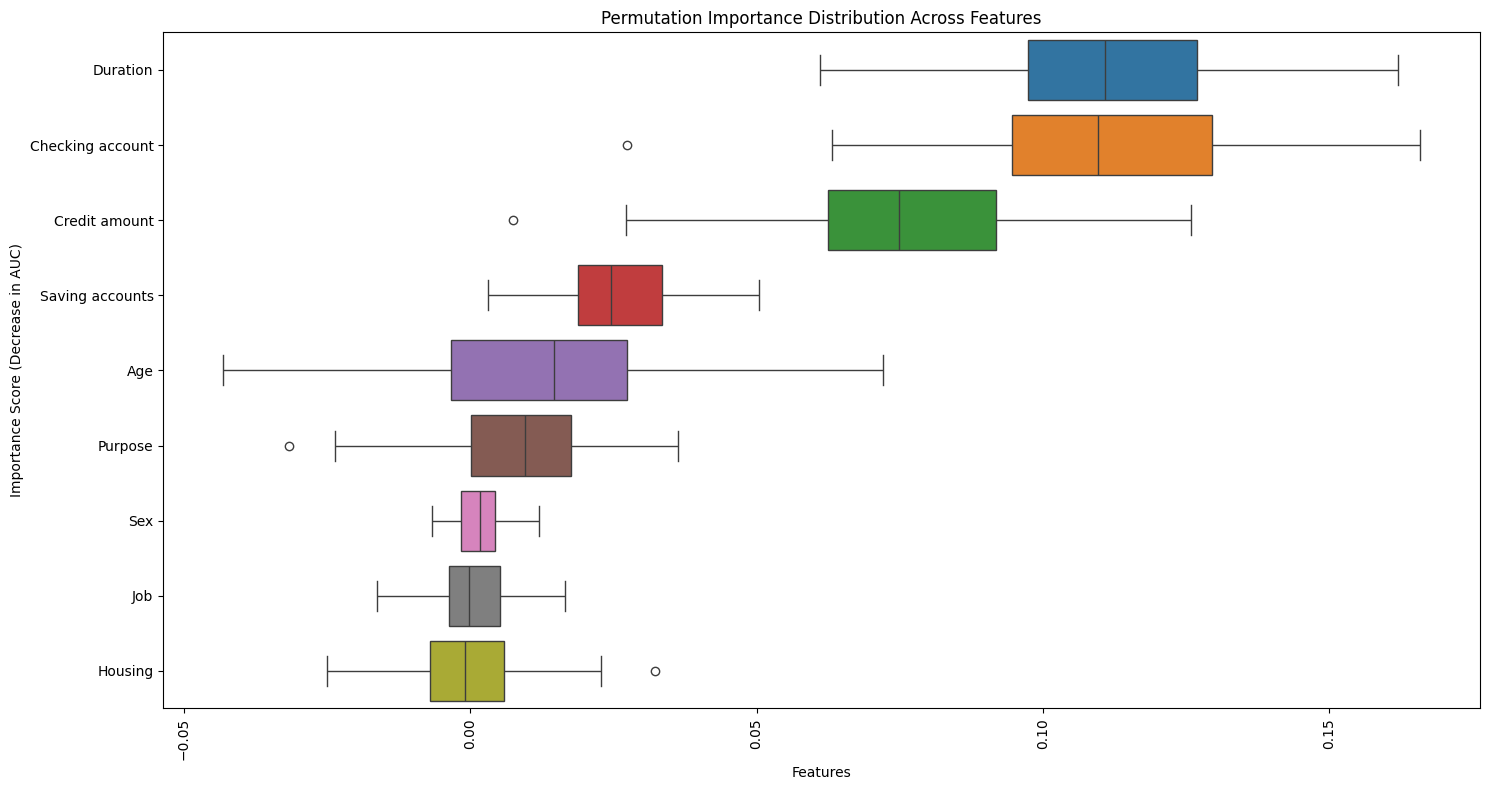

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 8))
sns.boxplot(data=perm_importance_df_ordered, orient="h")
plt.xticks(rotation=90)
plt.title('Permutation Importance Distribution Across Features')
plt.ylabel('Importance Score (Decrease in AUC)')
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [12]:
# let's calculate the ICE for teh feature Duration and for all samples of the test dataset
# you should first split duration distribution in 30 bins
# for every bins value calculate the prediction for all test sample
# plot all the curves in a lines plot

def ice_plot(feature_name, n_bins):
  bins = np.linspace(Xte[feature_name].min(), Xte[feature_name].max(), n_bins)
  ice_curves = []

  #start with the samples loop
  for i in range(len(Xte)):
    curve =  []
    # now the loop on the bins
    for bin in bins:
      # duplicate only the line i
      xi_bin = Xte.iloc[[i]]
      xi_bin[feature_name] = bin
      pred = model.predict_proba(xi_bin)[:,1]
      curve.append(pred[0])
    # we want to center the ICE curve and make it starts at 0
    curve = np.array(curve) - curve[0]
    ice_curves.append(curve)
    # plot all curves on the same graph
  plt.figure(figsize=(15, 8))
  for curve in ice_curves:
    plt.plot(bins, curve, color ="gray", alpha = 0.2)
    plt.xlabel(feature_name)
    plt.ylabel("Prediction")
    plt.title("ICE for " + feature_name)
  plt.show()

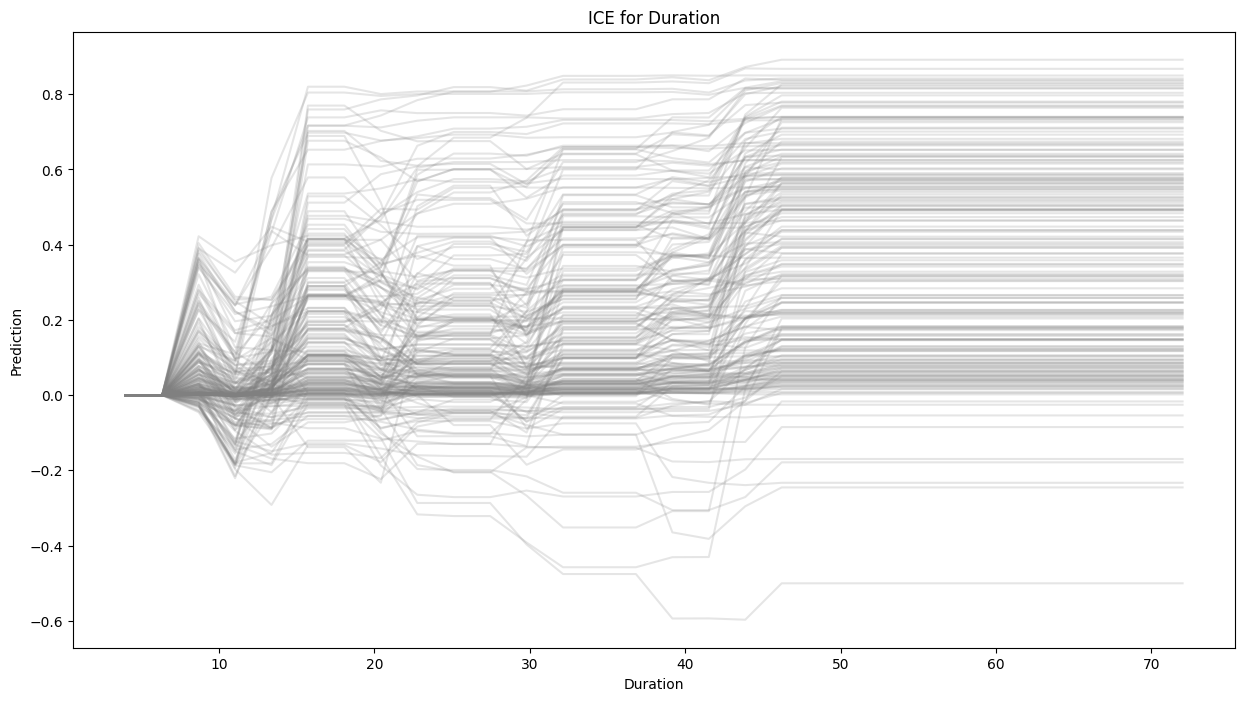

In [13]:
ice_plot("Duration", 30)

In [16]:
def PDP_curve(feature_name, n_bins):
  PDP_curve = []

  bins = np.linspace(Xte[feature_name].min(), Xte[feature_name].max(), n_bins)
  #start with bin
  for bin in bins:
    bin_values = []
    # instead of looping on the samples, we can copy whole dataset and change
    # and change bin for all lines
    x_bin = Xte.copy()
    x_bin[feature_name] = bin
    pred = model.predict_proba(x_bin)[:,1]
    PDP_curve.append(np.mean(pred))
    #plt the PDP
  plt.figure(figsize=(12, 6))
  plt.plot(bins, PDP_curve, color ="gray")
  plt.xlabel(feature_name)
  plt.ylabel("Prediction")
  plt.title("PDP for " + feature_name)

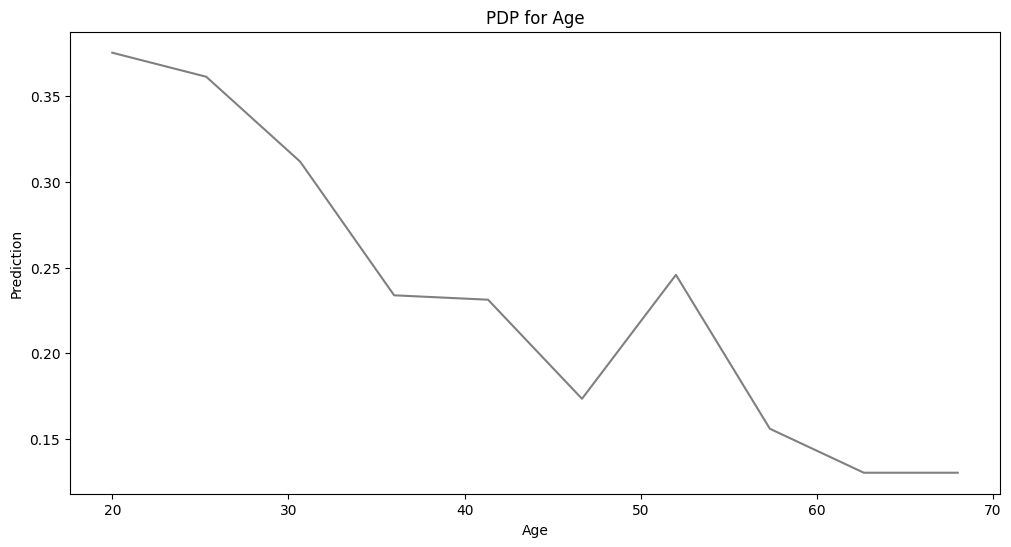

In [17]:
PDP_curve("Age", 10)